<img src='./img/LogoWekeo_Copernicus_RGB_0.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='20%'></img>

<a href="./00_index.ipynb"><< Index</a><br>
<a href="./20_Sentinel5P_TROPOMI_NO2_L2_retrieve.ipynb"><< 20 - Sentinel-5P NO<sub>2</sub> - Nitrogen Dioxide - Retrieve</a>

<div class="alert alert-block alert-warning">
<b>LOAD, BROWSE AND VISUALIZE</b></div>

# Copernicus Sentinel-5 Precursor (Sentinel-5P) - NO<sub>2</sub>

The subsequent example introduces you to Sentinel-5P data in general and the total column of NO<sub>2</sub> sensed by Sentinel-5P in specific. NO<sub>2</sub> is useful for monitoring air pollution. The example is based on elevated nitrogen dioxide levels in Europe which occurred in February 2021.


#### Module outline:
* [1 - Load and browse Sentinel-5P TROPOMI data](#load_s5P)
* [2 - Create a geographical subset](#geographical_subset)
* [3 - Visualize Sentinel-5P NO<sub>2</sub> data](#visualize_s5P)

#### Load required libraries

In [1]:
%matplotlib inline
import os
import xarray as xr
import numpy as np
import netCDF4 as nc

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

import subprocess
import shlex
import zipfile

from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-6ugjzlq5 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode
proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode


#### Load helper functions

In [2]:
%run ./functions.ipynb

<hr>

### Decompressing Sentinel-3 OLCI Level 1B Full Resolution data

The Sentinel-5P TROPOMI data could be not available on the machine. In this case there is the method to download them to [20 - Sentinel-5 TROPOMI NO2_Level 2 Retrieve](./20_Sentinel5P_TROPOMI_NO2_L2_retrieve.ipynb).

Also the user must extract the data before load them, if they are provided as a zip archive. If you have an already decompressed data this step is not necessary and the data can be directly loaded.

In [4]:
#rename S5 file
download_dir_path = os.getcwd()

for item in os.listdir(download_dir_path):
    if not os.path.isdir(item):
        cmd = shlex.split('file --mime-type {0}'.format(item))
        result = subprocess.check_output(cmd)
        mime_type = result.split()[-1]
        if item.startswith('S5P_OFFL_L2_') and not item.endswith('.zip') and mime_type == b'application/zip':
            os.rename(os.path.join(download_dir_path, item), os.path.join(download_dir_path, item +".zip"))

In case you have permission issues when renaming the archive with the code above, please manually do that by right-clicking the file, then rename, then add .zip to the end of the filename.

For example:
- From: S5P_OFFL_L2__NO2____20210205T104439_20210205T122609_17182_01_010400_20210207T042548   
- To: S5P_OFFL_L2__NO2____20210205T104439_20210205T122609_17182_01_010400_20210207T042548.zip

In [5]:
extension = ".zip"

for item in os.listdir(download_dir_path): # loop through items in dir
    print(item)
    if item.endswith(extension): # check for ".zip" extension
        file_name = os.path.join(download_dir_path, item) # get full path of files
        zip_ref = zipfile.ZipFile(file_name) # create zipfile object
        zip_ref.extractall(download_dir_path) # extract file to dir
        zip_ref.close() # close file
        

.ipynb_checkpoints
00_index.ipynb
10_CAMS_European_air_quality_forecast_retrieve.ipynb
11_CAMS_European_air_quality_forecast_NO2_load_browse.ipynb
20_Sentinel5P_TROPOMI_NO2_L2_retrieve.ipynb
21_Sentinel5P_TROPOMI_NO2_L2_load_browse.ipynb
S5P_OFFL_L2__NO2____20210205T104439_20210205T122609_17182_01_010400_20210207T042548.zip
_S5P_OFFL_L2__NO2____20210205T104439_20210205T122609_17182_01_010400_20210207T042548
adaptor.cams_regional_fc.retrieve-1637683377.4924982-25647-19-a2d4f922-aefa-497d-b56c-aac29b526ffb.nc
adaptor.cams_regional_fc.retrieve-1637684202.3786352-17332-19-df044dbe-b2fc-4b06-869e-bfc185c05d66.nc
adaptor.cams_regional_fc.retrieve-1637944391.6640477-7184-5-b06b97ad-573d-45f8-bd25-1276da172567.nc
adaptor.cams_regional_fc.retrieve-1639385759.2822495-18756-2-f1fd6140-71d3-46d4-969c-9fa9002e1b41.nc
adaptor.cams_regional_fc.retrieve-1639386345.927701-11665-8-6f955dd5-2a9a-4b23-8aa3-9f3c2c7ff2a9.nc
adaptor.cams_regional_fc.retrieve-1639386394.7797623-10500-6-8c293fdd-74b0-4f36-b627

## <a id="load_s5P"></a>Load and browse Sentinel-5P data

A Sentinel-5P file is organised in two groups: `PRODUCT` and `METADATA`. The `PRODUCT` group stores the main data fields of the product, including `latitude`, `longitude` and the variable itself. The `METADATA` group provides additional metadata items.

Sentinel-5P variables have the following dimensions:
* `scanline`: the number of measurements in the granule / along-track dimension index
* `ground_pixel`: the number of spectra in a measurement / across-track dimension index
* `time`: time reference for the data
* `corner`: pixel corner index
* `layer`: this dimension indicates the vertical grid of profile variables

Sentinel-5P TROPOMI data is disseminated in `netCDF`. You can load a `netCDF` file with the `open_dataset()` function of the xarray library. In order to load the variable as part of a Sentinel-5P data files, you have to specify the following keyword arguments: 
- `group='PRODUCT'`: to load the `PRODUCT` group

Let us load a Sentinel-5P TROPOMI data file as `xarray.Dataset` from 5 February 2021 and inspect the data structure:


In [6]:
s5P = xr.open_dataset('./S5P_OFFL_L2__NO2____20210205T104439_20210205T122609_17182_01_010400_20210207T042548/S5P_OFFL_L2__NO2____20210205T104439_20210205T122609_17182_01_010400_20210207T042548.nc', group='PRODUCT')
s5P

<xarray.Dataset>
Dimensions:                                               (scanline: 4172, ground_pixel: 450, time: 1, corner: 4, polynomial_exponents: 6, intensity_offset_polynomial_exponents: 1, layer: 34, vertices: 2)
Coordinates:
  * scanline                                              (scanline) float64 ...
  * ground_pixel                                          (ground_pixel) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column                   (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    averaging_kernel                                      (time, scanline, ground_pixel, layer) float32 ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (layer, vertices) float32 ...
    tm5_constant_b                                        (layer, vertices) float32 ...

You see that a Sentinel-5P data file consists of eight dimensions and twelve data variables:

* **Dimensions**:
  * `scanline` 
  * `ground_pixel`
  * `time`
  * `corner`
  * `polynomial_exponents`
  * `intensity_offset_polynomial_exponents`
  * `layer`
  * `vertices`

* **Data variables**:
  * `delta_time`: the offset of individual measurements within the granule, given in milliseconds
  * `time_utc`: valid time stamp of the data
  * `qa_value`: quality descriptor, varying between 0 (nodata) and 1 (full quality data).
  * `nitrogendioxide_tropospheric_column`: Vertically integrated NO<sub>2</sub> column density
  * `nitrogendioxide_tropospheric_column_precision`: Standard error of the vertically integrated NO<sub>2</sub> column
  
  As well as a few other variables:
  * `nitrogendioxide_tropospheric_column_precision_kernel`
  * `averaging_kernel`
  * `air_mass_factor_troposphere`
  * `air_mass_factor_total`
  * `tm5_tropopause_layer_index`
  * `tm5_constant_a`
  * `tm5_constant_b`

You can specify one variable of interest and get more detailed information about the variable. E.g. `nitrogendioxide_total_column` is the atmosphere mole content of NO<sub>2</sub>, has the unit `mol m-2` (which means `mol per m2`), and has three dimensions, `time`, `scanline` and `groundpixel` respectively.

In [7]:
s5P_no2 = s5P['nitrogendioxide_tropospheric_column']
s5P_no2

<xarray.DataArray 'nitrogendioxide_tropospheric_column' (time: 1, scanline: 4172, ground_pixel: 450)>
[1877400 values with dtype=float32]
Coordinates:
  * scanline      (scanline) float64 0.0 1.0 2.0 ... 4.17e+03 4.171e+03
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 447.0 448.0 449.0
  * time          (time) datetime64[ns] 2021-02-05
    latitude      (time, scanline, ground_pixel) float32 ...
    longitude     (time, scanline, ground_pixel) float32 ...
Attributes:
    units:                                                 mol m-2
    standard_name:                                         troposphere_mole_c...
    long_name:                                             Tropospheric verti...
    ancillary_variables:                                   nitrogendioxide_tr...
    multiplication_factor_to_convert_to_molecules_percm2:  6.02214e+19

You can do this for the available variables, but also for the dimensions latitude and longitude.

In [8]:
latitude = s5P_no2.latitude
latitude

<xarray.DataArray 'latitude' (time: 1, scanline: 4172, ground_pixel: 450)>
[1877400 values with dtype=float32]
Coordinates:
  * scanline      (scanline) float64 0.0 1.0 2.0 ... 4.17e+03 4.171e+03
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 447.0 448.0 449.0
  * time          (time) datetime64[ns] 2021-02-05
    latitude      (time, scanline, ground_pixel) float32 ...
    longitude     (time, scanline, ground_pixel) float32 ...
Attributes:
    long_name:      pixel center latitude
    units:          degrees_north
    standard_name:  latitude
    valid_min:      -90.0
    valid_max:      90.0
    bounds:         /PRODUCT/SUPPORT_DATA/GEOLOCATIONS/latitude_bounds

<br>

In [9]:
longitude = s5P_no2.longitude
longitude

<xarray.DataArray 'longitude' (time: 1, scanline: 4172, ground_pixel: 450)>
[1877400 values with dtype=float32]
Coordinates:
  * scanline      (scanline) float64 0.0 1.0 2.0 ... 4.17e+03 4.171e+03
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 447.0 448.0 449.0
  * time          (time) datetime64[ns] 2021-02-05
    latitude      (time, scanline, ground_pixel) float32 ...
    longitude     (time, scanline, ground_pixel) float32 ...
Attributes:
    long_name:      pixel center longitude
    units:          degrees_east
    standard_name:  longitude
    valid_min:      -180.0
    valid_max:      180.0
    bounds:         /PRODUCT/SUPPORT_DATA/GEOLOCATIONS/longitude_bounds

You can retrieve the array values of the variable with squared bracket: `[:,:,:]`. One single time step can be selected by specifying one value of the time dimension, e.g. `[0,:,:]`.

In [10]:
s5P_no2_0502 = s5P_no2[0,:,:]
s5P_no2_0502

<xarray.DataArray 'nitrogendioxide_tropospheric_column' (scanline: 4172, ground_pixel: 450)>
[1877400 values with dtype=float32]
Coordinates:
  * scanline      (scanline) float64 0.0 1.0 2.0 ... 4.17e+03 4.171e+03
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 447.0 448.0 449.0
    time          datetime64[ns] 2021-02-05
    latitude      (scanline, ground_pixel) float32 ...
    longitude     (scanline, ground_pixel) float32 ...
Attributes:
    units:                                                 mol m-2
    standard_name:                                         troposphere_mole_c...
    long_name:                                             Tropospheric verti...
    ancillary_variables:                                   nitrogendioxide_tr...
    multiplication_factor_to_convert_to_molecules_percm2:  6.02214e+19

The attributes of the data array hold the entry `multiplication_factor_to_convert_to_molecules_percm2`, which is a conversion factor that has to be applied to convert the data from `mol per m2` to `molecules per cm2`.


In [11]:
conversion_factor = s5P_no2_0502.multiplication_factor_to_convert_to_molecules_percm2
conversion_factor

6.02214e+19

Additionally, you can save the attribute `longname`, which you can make use of when visualizing the data.

In [12]:
longname = s5P_no2_0502.long_name
longname

'Tropospheric vertical column of nitrogen dioxide'

## <a id='geographical_subset'></a>Create  a geographical subset

You can zoom into a region by specifying a `bounding box` of interest. Let's set the extent to Europe with the following bounding box information:

In [13]:
latmin = 28.
latmax = 71.
lonmin = -22.
lonmax = 43

You can use the function [generate_geographical_subset()](./functions.ipynb#generate_geographical_subset) to subset an xarray DataArray based on a given bounding box.

In [14]:
s5P_no2_subset = generate_geographical_subset(s5P_no2_0502, latmin, latmax, lonmin, lonmax)
s5P_no2_subset

<xarray.DataArray 'nitrogendioxide_tropospheric_column' (scanline: 994, ground_pixel: 450)>
array([[          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ..., 2.2563152e-05,
        3.5298919e-05, 3.5160971e-05],
       [          nan,           nan,           nan, ..., 2.1023356e-05,
        2.0410715e-05, 2.4295245e-05],
       ...,
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan]], dtype=float32)
Coordinates:
  * scanline      (scanline) float64 2.91e+03 2.911e+03 ... 3.902e+03 3.903e+03
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 447.0 448.0 449.0
    time          datetime64[ns] 2021-02-05
    latitude      (scanline, ground_pixel) float32 22.47 22.51 ... 75.53 75.5
    longitude     (scanline, ground_pixel) float32 8.655 8.736 ... 36.78 37.09
Attributes:
    units:                                                 mol m-2
    standard_name:                                         troposphere_mole_c...
    long_name:                                             Tropospheric verti...
    ancillary_variables:                                   nitrogendioxide_tr...
    multiplication_factor_to_convert_to_molecules_percm2:  6.02214e+19

<br>

## <a id="plotting_s5P"></a>Plotting example - Sentinel-5P TROPOMI data

You can plot data arrays of type `numpy` with matplotlib's `pcolormesh` function. In combination with the library [cartopy](https://scitools.org.uk/cartopy/docs/latest/), you can produce high-quality maps. 

In order to make it easier to visualize the NO<sub>2</sub> values, we apply the conversion factor to the DataArray. This converts the NO<sub>2</sub> values from mol per m<sup>2</sup> to molecules per cm<sup>2</sup>.

In [15]:
s5P_no2_converted = s5P_no2_subset*conversion_factor
s5P_no2_converted

<xarray.DataArray 'nitrogendioxide_tropospheric_column' (scanline: 994, ground_pixel: 450)>
array([[          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ..., 1.3587846e+15,
        2.1257503e+15, 2.1174429e+15],
       [          nan,           nan,           nan, ..., 1.2660560e+15,
        1.2291618e+15, 1.4630936e+15],
       ...,
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan]], dtype=float32)
Coordinates:
  * scanline      (scanline) float64 2.91e+03 2.911e+03 ... 3.902e+03 3.903e+03
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 447.0 448.0 449.0
    time          datetime64[ns] 2021-02-05
    latitude      (scanline, ground_pixel) float32 22.47 22.51 ... 75.53 75.5
    longitude     (scanline, ground_pixel) float32 8.655 8.736 ... 36.78 37.09

The next step is to visualize the dataset. You can use the function [visualize_pcolormesh](../functions.ipynb#visualize_pcolormesh), which makes use of matploblib's function `pcolormesh` and the [Cartopy](https://scitools.org.uk/cartopy/docs/latest/) library.

With `?visualize_pcolormesh` you can open the function's docstring to see what keyword arguments are needed to prepare your plot.

In [16]:
?visualize_pcolormesh

Signature:
visualize_pcolormesh(
    data_array,
    longitude,
    latitude,
    projection,
    color_scale,
    unit,
    long_name,
    vmin,
    vmax,
    set_global=True,
    lonmin=-180,
    lonmax=180,
    latmin=-90,
    latmax=90,
)
Docstring:
Visualizes a xarray.DataArray with matplotlib's pcolormesh function.

Parameters:
    data_array(xarray.DataArray): xarray.DataArray holding the data values
    longitude(xarray.DataArray): xarray.DataArray holding the longitude values
    latitude(xarray.DataArray): xarray.DataArray holding the latitude values
    projection(str): a projection provided by the cartopy library, e.g. ccrs.PlateCarree()
    color_scale(str): string taken from matplotlib's color ramp reference
    unit(str): the unit of the parameter, taken from the NetCDF file if possible
    long_name(str): long name of the parameter, taken from the NetCDF file if possible
    vmin(int): minimum number on visualisation legend
    vmax(int): maximum number on visualisation

Now, let us apply the [visualize_pcolormesh](./functions#visualize_pcolormesh) function and visualize the vertically integrated NO<sub>2</sub> column sensored from the Sentinel-5P satellite on 5 February 2021.

Note: Multiplying the `DataArray` values with `1e-15` improves the readibility of the map legend.

/home/jovyan/.local/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = self._pcolormesh_patched(*args, **kwargs)


(<Figure size 1440x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'Tropospheric vertical column of nitrogen dioxide 2021-02-05T00:00:00.000000000'}>)

/home/jovyan/.local/lib/python3.8/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode
proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode
proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode
proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode


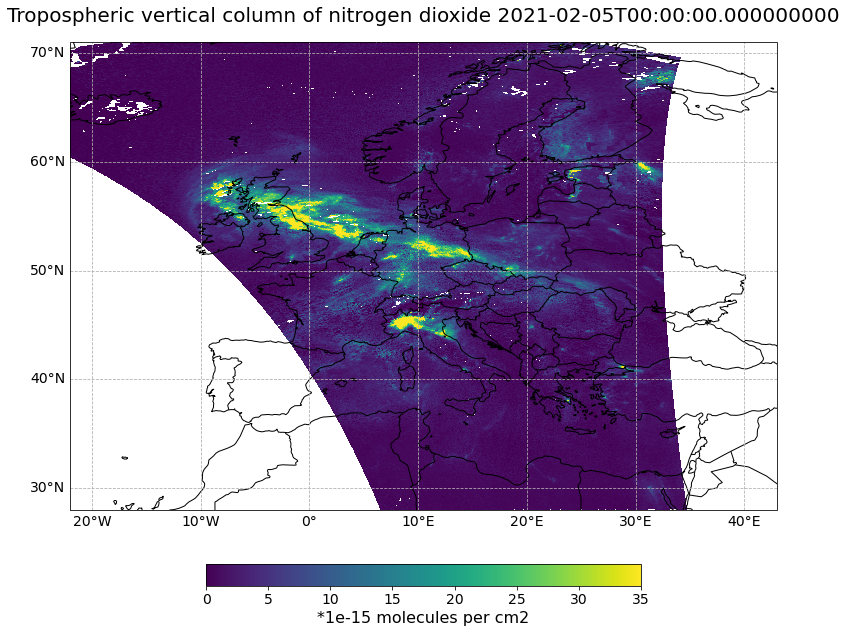

In [17]:
visualize_pcolormesh(data_array=s5P_no2_converted*1e-15,
                     longitude=s5P_no2_converted.longitude,
                     latitude=s5P_no2_converted.latitude,
                     projection=ccrs.PlateCarree(),
                     color_scale='viridis',
                     unit='*1e-15 molecules per cm2',
                     long_name=longname + ' ' + str(s5P_no2_converted.time.data),
                     vmin=0,
                     vmax=35,
                     lonmin=lonmin,
                     lonmax=lonmax,
                     latmin=latmin,
                     latmax=latmax,
                     set_global=False)

<br>

<a href="./00_index.ipynb"><< Index</a><br>
<a href="./20_Sentinel5P_TROPOMI_NO2_L2_retrieve.ipynb"> << 20 - Sentinel-5P NO<sub>2</sub> - Nitrogen Dioxide - Retrieve</a>

<hr>

<p><img src='./img/all_partners_wekeo.png' align='left' alt='Logo EU Copernicus' width='100%'></img><p>